<a href="https://colab.research.google.com/github/blackst3r/chenwei.github.io/blob/main/sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

In [81]:
import importlib
import sys
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from pytorch_transformers import RobertaTokenizer as tokenization


In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
print(os.listdir('/content/drive/My Drive/data/FAR_sections/'))

['Subpart-12.3.txt', 'Subpart-14.1.txt', 'Subpart-11.8.txt', 'Subpart-13.2.txt', 'Subpart-12.1.txt', 'Subpart-1.2.txt', 'Subpart-11.6.txt', 'Subpart-1.1.txt', 'Subpart-11.2.txt', 'Subpart-11.4.txt', 'Subpart-11.5.txt', 'Subpart-13.3.txt', 'Subpart-1.4.txt', 'Subpart-1.6.txt', 'Subpart-13.5.txt', 'Subpart-12.2.txt', 'Subpart-14.3.txt', 'Subpart-1.5.txt', 'Subpart-13.1.txt', 'Subpart-11.1.txt', 'Subpart-14.2.txt', 'Subpart-14.5.txt', 'Subpart-11.7.txt', 'Subpart-12.6.txt', 'Subpart-15.1.txt', 'Subpart-12.5.txt', 'Subpart-13.4.txt', 'Subpart-1.3.txt', 'Subpart-12.4.txt', 'Subpart-14.4.txt', 'Subpart-11.3.txt', 'Subpart-1.7.txt', 'Subpart-19.15.txt', 'Subpart-19.14.txt', 'Subpart-19.1.txt', 'Subpart-16.3.txt', 'Subpart-15.3.txt', 'Subpart-16.5.txt', 'Subpart-17.7.txt', 'Subpart-16.4.txt', 'Subpart-16.1.txt', 'Subpart-17.6.txt', 'Subpart-17.5.txt', 'Subpart-19.12.txt', 'Subpart-16.7.txt', 'Subpart-15.6.txt', 'Subpart-19.10.txt', 'Subpart-16.6.txt', 'Subpart-19.13.txt', 'Subpart-18.1.txt', '

# Creating S-BERT embeddings

In [98]:
def get_text_files(dir_path):
    text_files = {}

    for file in os.listdir(dir_path):
        if file.endswith(".txt"):  # 如果文件是文本文件
            try:
                with open(os.path.join(dir_path, file), 'r', encoding='utf-8') as f:
                    text = f.read()  # 试图以 UTF-8 编码读取文件
            except UnicodeDecodeError:
                try:
                    with open(os.path.join(dir_path, file), 'r', encoding='cp1252') as f:
                        text = f.read()  # 如果 UTF-8 读取失败，尝试以 CP1252 编码读取
                except UnicodeDecodeError:
                    with open(os.path.join(dir_path, file), 'r', encoding='latin1') as f:
                        text = f.read()  # 如果 CP1252 读取失败，尝试以 latin1 编码读取
            text_files[file] = text  # 将文件内容添加到字典

    return text_files

prime_path = '/content/drive/My Drive/data/prime_sections/'
far_path = '/content/drive/My Drive/data/FAR_sections/'

prime_dict = get_text_files(prime_path)
far_dict = get_text_files(far_path)

In [112]:
documents_dict = {**prime_dict, **far_dict}
docs = list(documents_dict.values())
prime_docs = list(prime_dict.values())
far_docs = list(far_dict.values())

Text(0.5, 1.0, 'FAR')

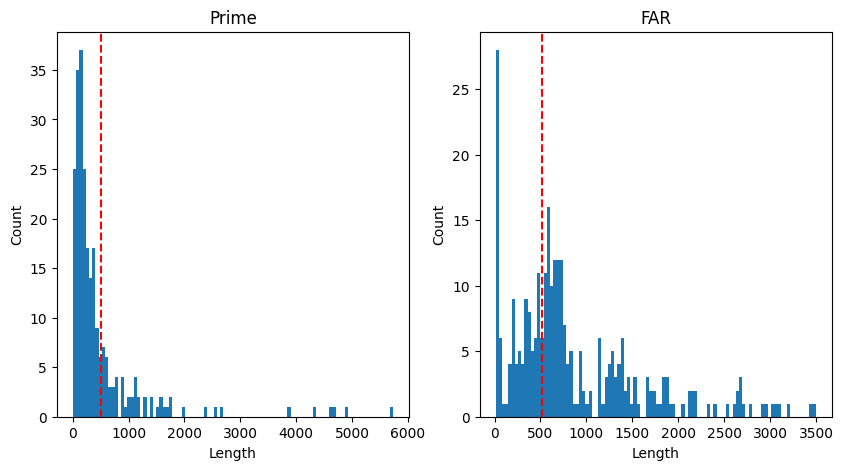

In [101]:
# many models often truncate at 512 tokens -- how does this affect our data?
word_count = [len(doc.split()) for doc in documents_dict.values()]
prime_word_count = [len(doc.split()) for doc in prime_dict.values()]
far_word_count = [len(doc.split()) for doc in far_dict.values()]
far_word_count = [x for x in far_word_count if x < 3500] # max value is 123,910!

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(prime_word_count, bins=100)
plt.axvline(x=512, color='r', linestyle='dashed', label = 'max length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Prime')

plt.subplot(1, 2, 2)
plt.hist(far_word_count, bins=100)
plt.axvline(x=512, color='r', linestyle='dashed', label = 'max length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('FAR')

In [113]:
model = SentenceTransformer('all-distilroberta-v1')
# dot product is better for longer documents
# try different models in the future

embeddings = model.encode(docs, convert_to_tensor=True)

In [115]:
# get the cosine scores for every pair, and reformat the dataframe
cosine_scores = cos_sim(embeddings, embeddings)
pairs = pd.DataFrame(np.array(cosine_scores), columns=documents_dict.keys(), index=documents_dict.keys())
pairs = pairs.stack().reset_index().rename(columns={'level_0': 'doc1', 'level_1': 'doc2', 0: 'cosine_score'})

In [116]:
pairs

,doc1,doc2,cosine_score
0,C.3.1.2.txt,C.3.1.2.txt,1.000000
1,C.3.1.2.txt,B.3.txt,0.529921
2,C.3.1.2.txt,C.3.1.1.txt,0.801050
3,C.3.1.2.txt,C.2.txt,0.700327
4,C.3.1.2.txt,C.1.txt,0.693649
...,...,...,...
309131,Subpart-9.6.txt,Subpart-9.5.txt,0.633798
309132,Subpart-9.6.txt,Subpart-9.2.txt,0.551715
309133,Subpart-9.6.txt,Subpart-9.7.txt,0.655153
309134,Subpart-9.6.txt,Subpart-9.3.txt,0.520815


# Analysis

Heatmap

<AxesSubplot:xlabel='doc2', ylabel='doc1'>

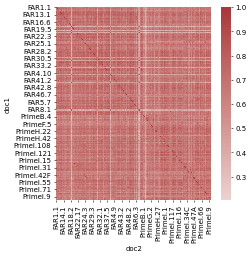

In [ ]:
utils.generate_heatmap(pairs, 5, "doc1",'doc2','cosine_score')

In [117]:
word_count_dict = dict(zip(documents_dict.keys(), word_count))
pairs['word_count'] = pairs['doc1'].map(word_count_dict) + pairs['doc2'].map(word_count_dict)

In [118]:
# to compare S-BERT with human evaluation on -1 to 1 scale
pairs['cosine_score1'] = pairs['cosine_score']*2 -1

Get pairs to manually evaluate

In [119]:
pairs['same_doc'] = pairs['doc1'].apply(lambda x: x[:3]) == pairs['doc2'].apply(lambda x: x[:3])

In [129]:
# we chose pairs that had the highest, lowest, and random sbert scores. we also kept them short so it was faster to read through
pairs.query('doc1 != doc2 and same_doc == False').query('word_count < 1000')\
    .sample(15)[['doc1','doc2','cosine_score1']]
    # .sort_values('cosine_score1', ascending= True)\
    # .head(30)[::2][['doc1','doc2','cosine_score1']]

,doc1,doc2,cosine_score1
132290,I.8B.txt,Subpart-6.4.txt,-0.065905
173115,Subpart-22.7.txt,I.63A.txt,-0.506404
129169,I.8D.txt,I.52.txt,-0.150596
137908,Subpart-12.1.txt,C.3.3.txt,0.091986
46709,I.10A.txt,B.1.txt,0.156968
184039,Subpart-22.3.txt,C.2.txt,-0.365094
13057,D.1.txt,Subpart-12.5.txt,-0.256401
8901,F.1.txt,B.1.txt,-0.359017
185158,Subpart-22.18.txt,E.2.txt,0.150063
24507,H.28.txt,H.40.txt,-0.076411


<Figure size 250x250 with 0 Axes>

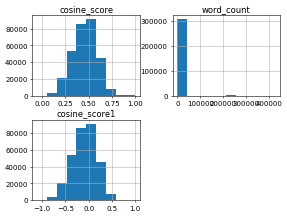

In [124]:
# what's the distribution of s-bert scores?
plt.figure(figsize=[5,5])
pairs.hist()
plt.title("S-BERT")
matplotlib.rcParams['figure.dpi'] = 50

In [130]:
pairs

,doc1,doc2,cosine_score,word_count,cosine_score1,same_doc
0,C.3.1.2.txt,C.3.1.2.txt,1.000000,300,1.000000,True
1,C.3.1.2.txt,B.3.txt,0.529921,677,0.059841,False
2,C.3.1.2.txt,C.3.1.1.txt,0.801050,243,0.602101,True
3,C.3.1.2.txt,C.2.txt,0.700327,289,0.400654,False
4,C.3.1.2.txt,C.1.txt,0.693649,677,0.387298,False
...,...,...,...,...,...,...
309131,Subpart-9.6.txt,Subpart-9.5.txt,0.633798,2017,0.267596,True
309132,Subpart-9.6.txt,Subpart-9.2.txt,0.551715,1863,0.103430,True
309133,Subpart-9.6.txt,Subpart-9.7.txt,0.655153,1573,0.310306,True
309134,Subpart-9.6.txt,Subpart-9.3.txt,0.520815,1285,0.041630,True
